In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

from factor_analyzer import FactorAnalyzer
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# 前処理

In [89]:
df = pd.read_csv('../data/0617_result_question.csv')
#列名クラスと人を消したい

#点数が高いほど、遅延したくなる
df["2-1"] = df["2-1"].map(lambda x:5-x)
df["2-3"] = df["2-3"].map(lambda x:5-x)
df["2-7"] = df["2-7"].map(lambda x:5-x)
df["3-4.国"] = df["3-4.国"].map(lambda x:5-x)
df["3-5.国"] = df["3-5.国"].map(lambda x:5-x)
df["3-4.英"] = df["3-4.英"].map(lambda x:5-x)
df["3-5.英"] = df["3-5.英"].map(lambda x:5-x)
df["3-4.数"] = df["3-4.数"].map(lambda x:5-x)
df["3-5.数"] = df["3-5.数"].map(lambda x:5-x)

df = df.drop(['クラス', '人'], axis=1)
df_math = df[[ '学年', '性別', '2-1', '2-2', '2-3', '2-4', '2-5', '2-6', '2-7', '3-1.数学', '3-2.数',
       '3-3.数', '3-4.数', '3-5.数']]

df_english = df[['学年', '性別', '2-1', '2-2', '2-3', '2-4', '2-5', '2-6', '2-7', '3-1.英語',  '3-2.英',  '3-3.英', '3-4.英', '3-5.英']]
df_japanese = df[['学年', '性別', '2-1', '2-2', '2-3', '2-4', '2-5', '2-6', '2-7', '3-1.国',  '3-2.国',  '3-3.国', '3-4.国', '3-5.国']]

#MBTI列以外で欠損ちがある行を削除
df_math = df_math.dropna(subset=['学年', '性別', '2-1', '2-2', '2-3', '2-4', '2-5', '2-6', '2-7', '3-1.数学', '3-2.数','3-3.数', '3-4.数', '3-5.数'])
#MBTI列以外で欠損ちがある行を削除
df_english = df_english.dropna(subset=['学年', '性別', '2-1', '2-2', '2-3', '2-4', '2-5', '2-6', '2-7', '3-1.英語',  '3-2.英',  '3-3.英', '3-4.英', '3-5.英'])
#MBTI列以外で欠損ちがある行を削除
df_japanese = df_japanese.dropna(subset=['学年', '性別', '2-1', '2-2', '2-3', '2-4', '2-5', '2-6', '2-7', '3-1.国',  '3-2.国',  '3-3.国', '3-4.国', '3-5.国'])

#数学のデータフレームを作成
df_math["Y_math"] = df_math["3-1.数学"].map(lambda x: 1 if x == "土" or x == "未"  else 0)
df_math = df_math.drop("3-1.数学", axis=1)
df_math = df_math.astype(int)
df_math = df_math.reset_index(drop=True)

#英語のデータフレームを作成
df_english["Y_english"] = df_english["3-1.英語"].map(lambda x: 1 if x == "土" or x == "未"  else 0)
df_english = df_english.drop("3-1.英語", axis=1)
df_english = df_english.astype(int)
df_english = df_english.reset_index(drop=True)

#国語のデータフレームを作成
df_japanese["Y_japanese"] = df_japanese["3-1.国"].map(lambda x: 1 if x == "土" or x == "未"  else 0)
df_japanese = df_japanese.drop("3-1.国", axis=1)
df_japanese = df_japanese.astype(int)
df_japanese = df_japanese.reset_index(drop=True)

# 因子分析(バリマックス回転)

In [90]:
def innsi(df):
    # データを標準化
    df = df.iloc[:, :-1]
    sc = StandardScaler()
    df_math_std = sc.fit_transform(df)

    # 因子分析のインスタンスを生成と適用
    fa = FactorAnalyzer(n_factors=3, rotation='varimax')
    fa.fit(df_math_std)

    # 因子負荷量を出力
    loadings = pd.DataFrame(fa.loadings_, columns=['第1因子', '第2因子', '第3因子'], index=df.columns)
    print(loadings)

    # 因子得点を算出
    factor_score = fa.transform(df_math_std)

    # 因子得点をデータフレームに変換
    factor_score_df = pd.DataFrame(factor_score, columns=['第1因子', '第2因子', '第3因子'])

    # 元のデータフレームと結合
    df_math = pd.concat([df, factor_score_df], axis=1)
    return df_math

In [91]:
df_math_innsi = innsi(df_math)
df_english_innsi = innsi(df_english)
df_japanese_innsi = innsi(df_japanese)

           第1因子      第2因子      第3因子
学年    -0.148733  0.843741  0.033827
性別    -0.269621  0.046088  0.148853
2-1    0.821390  0.161594  0.151367
2-2    0.162671 -0.179159  0.628023
2-3    0.108119  0.376655 -0.064568
2-4   -0.296756 -0.023454 -0.264673
2-5   -0.209108  0.130782  0.741002
2-6   -0.007295  0.324157  0.460908
2-7    0.228517 -0.103396  0.488314
3-2.数  0.332647 -0.839305 -0.021625
3-3.数  0.745683 -0.159776 -0.112144
3-4.数 -0.356392 -0.442285  0.580634
3-5.数  0.638390 -0.124974  0.308088
           第1因子      第2因子      第3因子
学年    -0.021650  0.464198 -0.003636
性別     0.180475  0.212176 -0.414155
2-1    0.166326 -0.031774  0.441341
2-2    0.718953 -0.261404  0.293429
2-3   -0.156768  0.248158 -0.051113
2-4   -0.131166 -0.361822 -0.512905
2-5    0.754310  0.447167 -0.382313
2-6    0.365799  0.498534  0.164768
2-7    0.496066 -0.002826  0.104632
3-2.英 -0.052068  0.673781  0.104477
3-3.英  0.004191  0.229379  0.468210
3-4.英  0.489477 -0.428549 -0.210755
3-5.英  0.510083 -0.020373  0

# ロジスティック回帰

In [92]:
def lr(df,df_innsi):
    
    lr = LogisticRegression(random_state=0)

    # ロジスティック回帰を実行
    #テストデータと分割
    
    X = df_innsi[['第1因子', '第2因子', '第3因子']]
    # target_string = "Y"
    # columns_with_target_string = [col for col in df_innsi.columns if target_string in col]
    y = df.iloc[:,-1:]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

    lr.fit(X_train, y_train)

    # テストデータを予測
    y_pred = lr.predict(X_test)

    # テストデータに対する正答率を出力
    print('テストデータに対する正答率： %.3f' % accuracy_score(y_test, y_pred))

    #回帰係数を出力
    # lr.coef_を可視化
    coef_df = pd.DataFrame(lr.coef_, columns=['第1因子', '第2因子', '第3因子'])
    
    plt.figure(figsize=(7, 2))
    sns.set(font='IPAexGothic')
    sns.barplot(data=coef_df, orient='h')
    plt.show()

/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


テストデータに対する正答率： 0.800


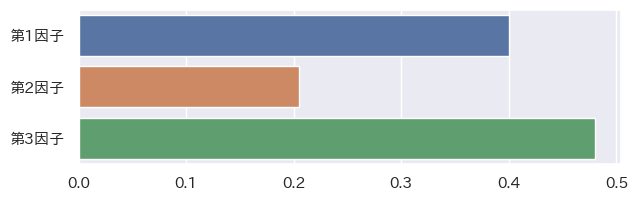

In [93]:
lr(df_math,df_math_innsi)

/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


テストデータに対する正答率： 0.778


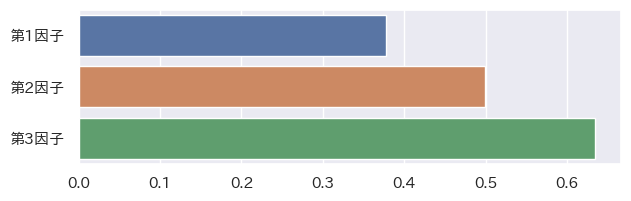

In [94]:
lr(df_english,df_english_innsi)

/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


テストデータに対する正答率： 0.500


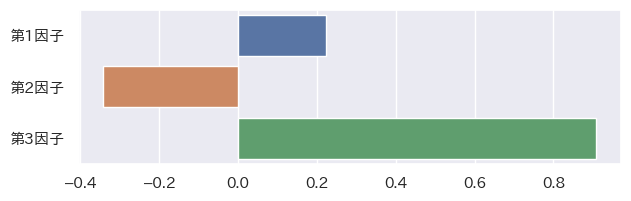

In [95]:
lr(df_japanese,df_japanese_innsi)